In [ ]:
#| hide
from nbdev.showdoc import *

# Testing R-Python Integration
> This notebook demonstrates and validates the bidirectional data exchange between R and Python using the RPy2 library. 

- skip_exec: true

In [ ]:
#reload when modified
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
from IPython.display import Image, display
import os
import re
import tqdm

In [ ]:
import svist4get as sv4g

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import utilities as UT
import missingno as msno
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc
from io import StringIO
from itertools import islice
from Bio import SeqIO

random.seed(1976)
np.random.seed(1976)

In [ ]:
import multiprocessing
multiprocessing.cpu_count()

12

In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)
# Create a DataFrame with 6 columns and 100 rows of random values
df = pd.DataFrame({
    'A': np.random.randint(0, 1000, size=100),
    'B': np.random.randint(0, 1000, size=100),
    'C': np.random.randint(0, 1000, size=100),
    'D': np.random.randint(0, 1000, size=100),
    'E': np.random.randint(0, 1000, size=100),
    'F': np.random.randint(0, 1000, size=100),
})

# Display the first few rows
print(df.shape)
df.head()

(100, 6)


,A,B,C,D,E,F
0,102,555,899,709,472,322
1,435,161,733,415,98,871
2,860,201,484,246,152,685
3,270,957,406,835,860,791
4,106,995,230,438,913,625


In [ ]:
%%R -i df
options(warn=-1)
library("limma") 
library("edgeR")
library("cqn")
library("scales")
head(df)

    A   B   C   D   E   F
0 102 555 899 709 472 322
1 435 161 733 415  98 871
2 860 201 484 246 152 685
3 270 957 406 835 860 791
4 106 995 230 438 913 625
5  71 269 748 202 895 287


In [ ]:
%%R -o df
group <- factor(c(
    'A','A','A','B','B','B'
))

y <- DGEList(counts=df, group=group)
keep <- filterByExpr(y, min.count = 100, min.total.count = 2000)
y <- y[keep,,keep.lib.sizes=FALSE]
counts = y$counts
genes = row.names(y)

In [ ]:
%R -o counts,genes
indata = pd.DataFrame(counts, index=genes,columns=df.columns)
indata.shape

(95, 6)

In [ ]:
%%R -i indata
#https://rstudio-pubs-static.s3.amazonaws.com/79395_b07ae39ce8124a5c873bd46d6075c137.html
library(edgeR)
# Make groups
design_with_all <- model.matrix( ~0+group )

y <- DGEList(counts=indata, 
                  group = group, 
                  )
# Estimate dispersion
y <- estimateGLMCommonDisp( y, design_with_all )
y <- estimateGLMTrendedDisp( y, design_with_all )
y <- estimateGLMTagwiseDisp( y, design_with_all )
# Fit counts to model
fit_all <- glmQLFit( y, design_with_all )


In [ ]:
%%R
contrast <- glmQLFTest(fit_all, contrast=makeContrasts( groupA-groupB, levels=design_with_all ) )
table <- topTags(contrast, n=Inf, sort.by = "none", adjust.method="BH")$table
head(table)

        logFC   logCPM           F    PValue       FDR
0  0.06557184 13.34298 0.005041796 0.9443735 0.9720116
1  0.04093098 13.14642 0.001779103 0.9669370 0.9720116
2  0.63822136 13.12779 0.463060552 0.5070295 0.9720116
3 -0.55146249 13.77109 0.776125452 0.3928463 0.9720116
4 -0.51958511 13.45730 0.310887813 0.5857299 0.9720116
5 -0.34783483 13.03854 0.114259640 0.7402404 0.9720116


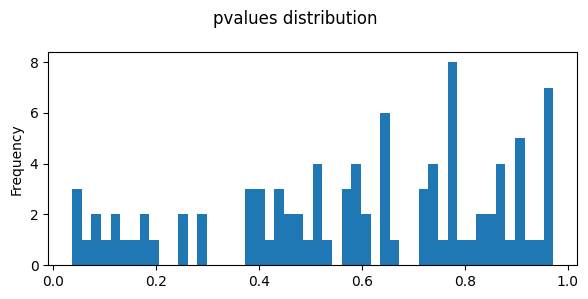

In [ ]:
%R -o table
fig,axes=plt.subplots(ncols=1,nrows=1,figsize=(6,3))
table.PValue.plot(kind='hist',bins=50,ax=axes)
plt.suptitle('pvalues distribution')
plt.tight_layout()
plt.show()

In [ ]:
import panel as pn
import holoviews as hv
import numpy as np

# Initialize panel and holoviews
pn.extension()
hv.extension('bokeh')

# Generate some data
x = np.arange(10)
y = np.random.rand(10)

# Create a scatter plot
scatter = hv.Scatter((x, y)).opts(
    width=400, height=300, 
    tools=['hover', 'tap'],
    size=10, 
    color='blue',
    title='Click on points to see data'
)

# Create a tap stream connected to our scatter plot
tap = hv.streams.Tap(source=scatter)

# Create a DynamicMap that updates with tap events
def tap_info(x, y):
    if x is None or y is None:
        return hv.Div('Click on a point')
    return hv.Div(f'Clicked point at x={x:.2f}, y={y:.4f}')

tap_display = hv.DynamicMap(tap_info, streams=[tap])

# Create layout and serve
layout = pn.Column(
    pn.pane.HoloViews(scatter),
    pn.pane.HoloViews(tap_display)
)

# Serve the application
layout.servable()

Column
    [0] HoloViews(Scatter, height=300, sizing_mode='fixed', width=400)
    [1] HoloViews(DynamicMap, height=300, width=300)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()